# Automating the annotation of dataset using Grounded-SAM
https://roboflow.com/model/grounded-sam

## Installs

In [ ]:
!pip install autodistill-grounded-sam roboflow rf_groundingdino rf_segment_anything supervision autodistill
!pip install -q git+https://github.com/huggingface/transformers.git datasets
!pip install fiftyone==1.7.1 > /dev/null

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology
from autodistill.utils import plot
import cv2
from PIL import Image
import numpy as np

## Image from HF

In [ ]:
# Load dataset
from datasets import load_dataset
dataset = load_dataset("EduardoPacheco/FoodSeg103")
dataset


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 4983
    })
    validation: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 2135
    })
})

In [ ]:
# Classes
id2label = {
    0: "background",
    1: "candy",
    2: "egg tart",
    3: "french fries",
    4: "chocolate",
    5: "biscuit",
    6: "popcorn",
    7: "pudding",
    8: "ice cream",
    9: "cheese butter",
    10: "cake",
    11: "wine",
    12: "milkshake",
    13: "coffee",
    14: "juice",
    15: "milk",
    16: "tea",
    17: "almond",
    18: "red beans",
    19: "cashew",
    20: "dried cranberries",
    21: "soy",
    22: "walnut",
    23: "peanut",
    24: "egg",
    25: "apple",
    26: "date",
    27: "apricot",
    28: "avocado",
    29: "banana",
    30: "strawberry",
    31: "cherry",
    32: "blueberry",
    33: "raspberry",
    34: "mango",
    35: "olives",
    36: "peach",
    37: "lemon",
    38: "pear",
    39: "fig",
    40: "pineapple",
    41: "grape",
    42: "kiwi",
    43: "melon",
    44: "orange",
    45: "watermelon",
    46: "steak",
    47: "pork",
    48: "chicken duck",
    49: "sausage",
    50: "fried meat",
    51: "lamb",
    52: "sauce",
    53: "crab",
    54: "fish",
    55: "shellfish",
    56: "shrimp",
    57: "soup",
    58: "bread",
    59: "corn",
    60: "hamburg",
    61: "pizza",
    62: "hanamaki baozi",
    63: "wonton dumplings",
    64: "pasta",
    65: "noodles",
    66: "rice",
    67: "pie",
    68: "tofu",
    69: "eggplant",
    70: "potato",
    71: "garlic",
    72: "cauliflower",
    73: "tomato",
    74: "kelp",
    75: "seaweed",
    76: "spring onion",
    77: "rape",
    78: "ginger",
    79: "okra",
    80: "lettuce",
    81: "pumpkin",
    82: "cucumber",
    83: "white radish",
    84: "carrot",
    85: "asparagus",
    86: "bamboo shoots",
    87: "broccoli",
    88: "celery stick",
    89: "cilantro mint",
    90: "snow peas",
    91: "cabbage",
    92: "bean sprouts",
    93: "onion",
    94: "pepper",
    95: "green beans",
    96: "French beans",
    97: "king oyster mushroom",
    98: "shiitake",
    99: "enoki mushroom",
    100: "oyster mushroom",
    101: "white button mushroom",
    102: "salad",
    103: "other ingredients"
}

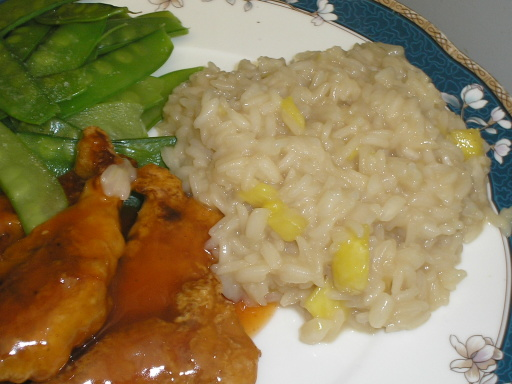

In [ ]:
example = dataset["train"][0]
image = example["image"]
image

In [ ]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [ ]:
image.size

(512, 384)

## Image from Workshop

In [ ]:
def resize_image(image,factor=0.25):
  return image.resize(size=(int(w*factor),int(h*factor)))

In [ ]:
%cd "/content/drive/MyDrive/Projets/Kanu AI/images-foodwaste"
!ls

/content/drive/MyDrive/Projets/Kanu AI/images-foodwaste
 annotated
'Copy of Train_a_linear_classifier_on_top_of_DINOv2_for_semantic_segmentation.ipynb'
 Rice48_Potatoes101_Goulash129
 weighed_dataset


In [ ]:
image_path = "./weighed_dataset/Goulash129/20250801_153845.jpg"
image = Image.open(image_path)
w,h=image.size
w,h

(2992, 2992)

(748, 748)


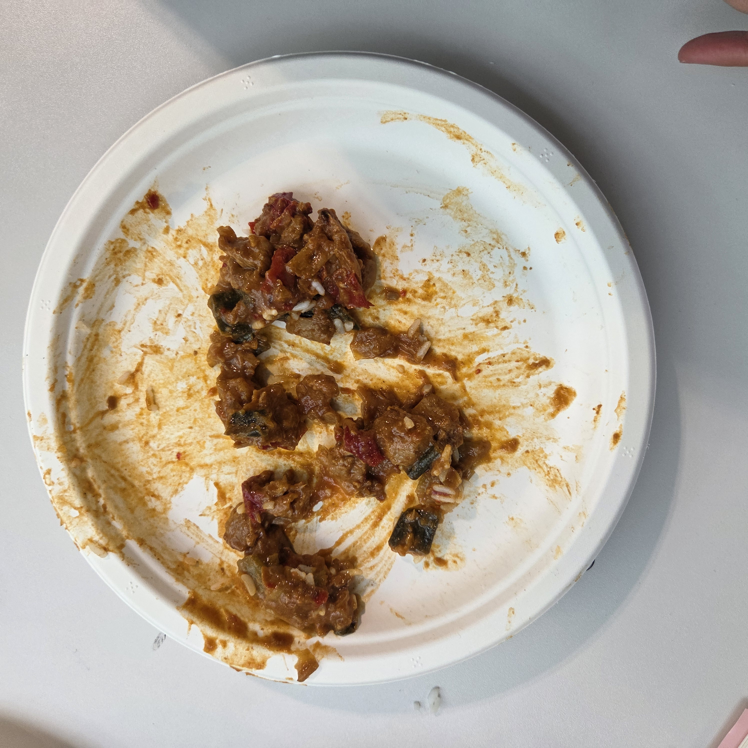

In [ ]:
factor=0.25
image_resized = resize_image(image,factor)

In [ ]:
small_ontology = {
            "goulash": "goulash",
            "rice": "rice",
            "potatoes": "potatoes"
        }
ingredients = id2label.values()
large_ontology = dict(zip(ingredients,ingredients))

In [ ]:
# define an ontology to map class names to our GroundedSAM prompt
# the ontology dictionary has the format {caption: class}
# where caption is the prompt sent to the base model, and class is the label that will
# be saved for that caption in the generated annotations
# then, load the model
base_model = GroundedSAM(
    ontology=CaptionOntology(large_ontology)
)

len(base_model.ontology.classes())

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


41

In [ ]:
# run inference on a single image
results = base_model.predict(image_resized)

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


In [ ]:
type(results)

supervision.detection.core.Detections

In [ ]:
results.mask.shape

(54, 748, 748)

In [ ]:
image_resized.size

(748, 748)

In [ ]:
#results.confidence[-5:]
topk = np.argsort(results.confidence)[-5:]

In [ ]:
classes_names = base_model.ontology.classes()
topk_classes = [classes_names[i] for i in results.class_id[topk].tolist()]
topk_classes

['sauerkraut', 'potatoes', 'mashed-potatoes', 'diced-potatoes', 'cauliflower']

In [ ]:
results_topk = deepcopy(results)
for a in ["confidence","mask","xyxy"]:
  setattr(results_topk,a,getattr(results_topk,a)[topk])

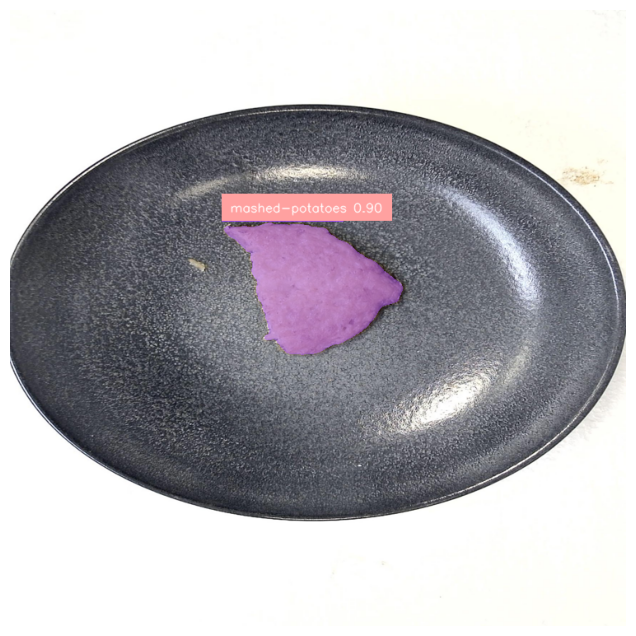

In [ ]:
plot(
    image=fo_image_resized,
    classes=topk_classes,
    detections=results_topk
)

In [ ]:
# add mask to fiftyone sample
#sample["estimated-mask"] = fo.Segmentation(mask=results_topk.mask)
#sample.save()
#foodwaste_dataset.save()

## Update fiftyone dataset

In [ ]:
from copy import deepcopy
import supervision as sv
from tqdm import tqdm
import fiftyone as fo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def resize_image(image,factor=0.25):
  w,h = image.size
  return image.resize(size=(int(w*factor),int(h*factor)))

In [ ]:
export_path = "/content/drive/MyDrive/Projets/Kanu AI/images-foodwaste/food_waste_part_1"
foodwaste_dataset = fo.Dataset.from_dir(
    dataset_dir=str(export_path),
    dataset_type=fo.types.FiftyOneDataset
)

fo.list_datasets()

Importing samples...


INFO:fiftyone.utils.data.importers:Importing samples...


 100% |█████████████████| 375/375 [100.2ms elapsed, 0s remaining, 3.7K samples/s]     


INFO:eta.core.utils: 100% |█████████████████| 375/375 [100.2ms elapsed, 0s remaining, 3.7K samples/s]     


['2025.08.05.15.52.26.059981', '2025.08.05.16.58.51.124488']

In [ ]:
foodwaste_dataset.get_field_schema()

OrderedDict([('id', <fiftyone.core.fields.ObjectIdField at 0x7ebe3d601050>),
             ('filepath',
              <fiftyone.core.fields.StringField at 0x7ebe3d602790>),
             ('tags', <fiftyone.core.fields.ListField at 0x7ebe3d602ed0>),
             ('metadata',
              <fiftyone.core.fields.EmbeddedDocumentField at 0x7ebe3d2cf3d0>),
             ('created_at',
              <fiftyone.core.fields.DateTimeField at 0x7ebe3d6bfc50>),
             ('last_modified_at',
              <fiftyone.core.fields.DateTimeField at 0x7ebe3d6bef90>),
             ('split', <fiftyone.core.fields.StringField at 0x7ebe3d2cf390>),
             ('bonid', <fiftyone.core.fields.IntField at 0x7ebe3d7e6f50>),
             ('bon_id', <fiftyone.core.fields.ListField at 0x7ebe3d6a5a90>),
             ('article_number',
              <fiftyone.core.fields.ListField at 0x7ebe3d6bf4d0>),
             ('ingredient_name',
              <fiftyone.core.fields.ListField at 0x7ebe3d6bf550>),
             ('

In [ ]:
#session = fo.launch_app(foodwaste_dataset, auto=False)
#print(session.url)

In [ ]:
def sv_to_fo_detections(detection,image_width,image_height,classes_names):
  num_detections = detection.confidence.shape[0]
  fo_detections = []

  assert len(classes_names) == num_detections

  bbox = sv.xyxy_to_xywh(xyxy=detection.xyxy)
  bbox[:,[0,2]] /= image_width
  bbox[:,[1,3]] /= image_height

  for i in range(num_detections):
    det = fo.Detection(bounding_box=bbox[i], label=classes_names[i],
                mask=detection.mask[i])
    fo_detections.append(det)

  return fo.Detections(detections=fo_detections)

In [ ]:
ingredient_names = set()
for sample in foodwaste_dataset:
  ingredient_names = ingredient_names.union(sample['ingredient_name'])

ingredient_names = [str(i).replace(")","") for i in list(ingredient_names)]
ingredient_names

['gravy',
 'chicken-strips',
 'sauerkraut',
 'rice',
 'onion',
 'diced-potatoes',
 'light-sauce-or-white-sauce',
 'cauliflower',
 'zucchini-or-courgette',
 'carrot',
 'cream',
 'green-beans',
 'ham-sausage',
 'dressing-portion',
 'potatoes',
 'chicken',
 'mushrooms',
 'schnitzel-or-cutlet',
 'egg-spaetzle',
 'mashed-potatoes',
 'paprika-or-bell-pepper',
 'iceberg-lettuce',
 'poached-meatballs',
 'coleslaw',
 'lentil-stew',
 'pollock-or-coalfish',
 'malt-beer-mustard-sauce',
 'grilled-sausage',
 'bread-dumplings',
 'vegetable-based-cream',
 'applesauce',
 'savoy-cabbage',
 'peas',
 'brown-sauce',
 'lentils',
 'red-cabbage',
 'roast-beef',
 'breaded-fish-fillet',
 'tomato-curry-sauce',
 'pork-neck-roast',
 'potato-pancakes-or-potato-fritters']

In [ ]:
large_ontology = dict(zip(ingredient_names,ingredient_names))
base_model = GroundedSAM(
    ontology=CaptionOntology(large_ontology)
)

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


In [ ]:
fo_dataset_new = fo.load_dataset("food_waste_part_1_samples")

In [ ]:
#--Very slow
max_samples = 30
classes_names = base_model.ontology.classes()
samples = []
for i,sample in tqdm(enumerate(foodwaste_dataset)):

  if i==max_samples:
    break

  filepath = sample.filepath
  fo_image = Image.open(filepath)
  #fo_image = resize_image(fo_image,0.25)
  results = base_model.predict(fo_image)
  topk = np.argsort(results.confidence)[-5:]
  topk_classes = [classes_names[i] for i in results.class_id[topk].tolist()]
  results_topk = deepcopy(results)
  for a in ["confidence","mask","xyxy"]:
    setattr(results_topk,a,getattr(results_topk,a)[topk])

  w,h=fo_image.size
  fo_detections = sv_to_fo_detections(results_topk,w,h,topk_classes)
  samples.append(fo.Sample(filepath=filepath,detections=fo_detections))


0it [00:00, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
30it [13:43, 27.45s/it]


In [ ]:
fo_dataset_new.add_samples(samples)
fo_dataset_new.save()

 100% |███████████████████| 30/30 [3.0s elapsed, 0s remaining, 11.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 30/30 [3.0s elapsed, 0s remaining, 11.6 samples/s]      


In [ ]:
fo_dataset_new.export(export_dir="/content/drive/MyDrive/Projets/Kanu AI/images-foodwaste/food_waste_part_1_samples_with_sam",
                      dataset_type=fo.types.FiftyOneDataset, #fo.types.COCODetectionDataset,
                      label_field="detections"
                      )

 100% |███████████████████| 30/30 [8.6s elapsed, 0s remaining, 2.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 30/30 [8.6s elapsed, 0s remaining, 2.5 samples/s]      


In [ ]:
# label all images in a folder called `context_images`
#base_model.label(input_folder="/content/drive/MyDrive/Projets/Kanu AI/images-foodwaste/food_waste_part_1_samples",
#                 output_folder="/content/drive/MyDrive/Projets/Kanu AI/images-foodwaste/food_waste_part_1_with_sam",
#                 extension=".jpg")

NameError: name 'base_model' is not defined

## Load fiftyone dataset

In [1]:
!pip install fiftyone

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import fiftyone as fo

In [4]:
name = "foodwaste"
dataset_dir = "/content/drive/MyDrive/Projets/Kanu AI/images-foodwaste/food_waste_part_1_samples_with_sam"

In [7]:
# Create the dataset
foodwaste_dataset = fo.Dataset.from_dir(
    dataset_dir=dataset_dir,
    dataset_type=fo.types.COCODetectionDataset,
    name=name,
)

# View summary info about the dataset
print(foodwaste_dataset)

# Print the first few samples in the dataset
print(foodwaste_dataset.head())

ValueError: Dataset name 'foodwaste' is not available

In [9]:
foodwaste_dataset = fo.load_dataset("foodwaste")

In [10]:
session = fo.launch_app(foodwaste_dataset, auto=False)
print(session.url)

Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.7.2

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.7.2

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



https://5151-m-s-3im60dcfqrekz-c.us-central1-1.prod.colab.dev?polling=true
